---
title: "Automatic differentiation"
author: "Marcin Płodzień"
toc: true
number-sections: true
highlight-style: pygments
jupyter: python3
skip_showdoc: true
skip_exec: true
---

# Calculating gradients

Methods for the computation of derivatives in computer programs can be classified into three
categories: 

 

## Numerical differentiation within finite difference approximation

For a given function $f: \mathbb{R}^m \to \mathbb{R}$, the components of its gradient

\begin{equation}
    \nabla f = (\frac{\partial f}{\partial x_1},\cdots,\frac{\partial f}{\partial x_m}),
\end{equation}
can be approximated as
\begin{equation}
 \frac{\partial f(\vec{x})}{\partial x_i} \sim \frac{ f(\vec{x} + h\vec{e}_i) - f(\vec{x})}{h},
\end{equation} 
where $\vec{e}_i \in \mathbb{R}^m$ is the $i$-th unit vector and $h$ is small step size.
However, aproximating $\nabla f$ requires $\mathcal{O}(m)$ evaluations of f. Additionally round-off errors due 
to floating-point arithmetic dominate the errors as $h\to 0$.


## Symbolic differentiation 

Calculating derivatives is done by automated manipulation of mathematical expressions allowing obtain explicit results (with help of computer algebra systems such us Mathematica, Maple, Maxima). For example for two given functions $f(x)$ and $g(x)$ derivative of their product is calculated explicitly following

\begin{equation}
\frac{d}{dx}(f(x)g(x)) = \frac{df(x)}{x}g(x) + f(x)\frac{dg(x)}{dx}   
\end{equation}

   The benefit of symbolic expression is that results are interpretable and allow find analytical solutions. However, symbolic derivatives generated through symbolic differentation typically do not allow for efficient calculations of derivative values.
   

## Automatic differentiation (AD)
    
Automatic differentiation allows to obtain exact numerical value of the derivatives without the
need of the symbolic expression - this method lies between symbolic differentiation and numerical differentiation.

The logic lying behind AD is that all numerical computations are compositions of a finite set of elementary operations for which derivatives are known. By combining the derivatives of the constituent operations through the computational diagram, and applying the chain rule for derivatives, we can obtain exact numerical of the derivative of the overall expression for a given input.

# Computational graph

A computational graph is a graph-based representation of a mathematical computation. It is a way of visually representing the operations performed in a computation, and the dependencies between these operations.

## Forward function evaluation

Let us consider expression $f(x_1,x_2) = \ln x_1 + \cos x_2 - x_1 x_2$, 
Function $f$ is a mapping $f: \mathbb{R}^n \to \mathbb{R}^m$ with $n = 2$, $m=1$.

Following [1], we introduce the notation for the computational graph as follows:

 1. Input variables are denoted as $v_{1-i}$, where $i = 1,\dots,n$.
 
 2. Intermediate variables are denoted as $v_i$, $i = 1,\dots,l$.
 
 3. Output variables are denoted as $v_{l+i}$, $i = 1,\dots,m$.
 
The computational graph related to considered function $f(x_1,x_2)$ is


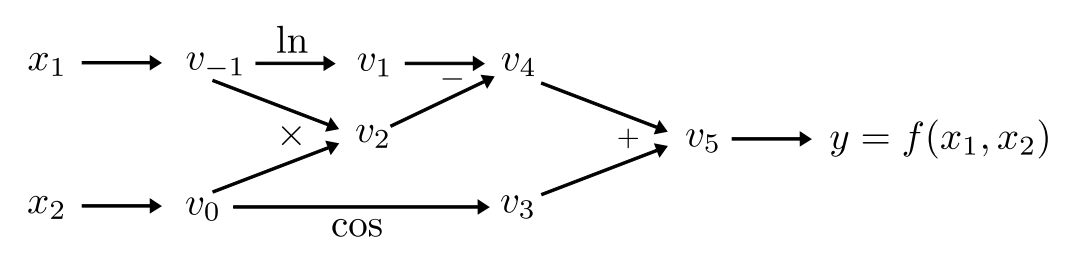

::: {.callout-tip}
### Exercise
Calculate value of $f(x_1,x_2)$ at $(x_1, x_2) = (2,1)$ via passing the diagram from left to right:
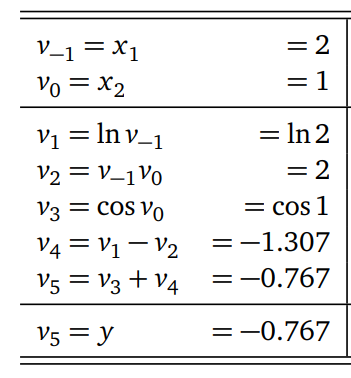
:::




## Calculating gradients

Automatic differentiation allows us to calculate exact value of the gradient at given point. In our example, we are interested in value of $\frac{\partial f}{\partial x_1}$ at given point $(x_1, x_2) = (2,1)$. This can be obtain in two modes.

### Forward-mode AD

Forward-mode AD is implemented by complementing each intermediate variable $v_i$ with a derivative:
\begin{equation}
\dot{v}_i = \frac{\partial v_i}{\partial x_1},
\end{equation}
and by applying chain rule for differentiation we can obtain desired gradient.
Derivativeas are propagated forward in sync with the function evaluation.

::: {.callout-tip}
### Exercise
Calculate value of $\frac{\partial f}{\partial x_1} = \dot{v}_5$ at $(x_1, x_2) = (2,1)$ through passing the diagram:
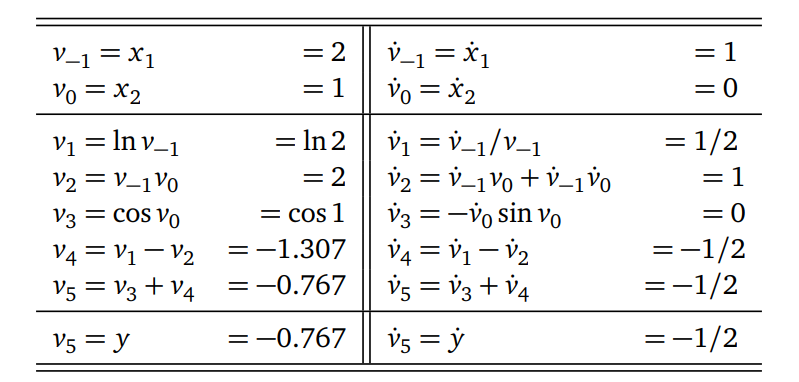
:::


::: {.callout-note}
### Dual numbers and forward-mode AD
In practive, forward-mode is implemented by extending the algebra of real numbers via introducing $\textit{dual}$ numbers, defined as
\begin{equation}
 \tilde{z}_1 = a_1 +\epsilon b_1,
\end{equation}
where $a,b \in \mathbb{R}$, and $\epsilon^2 = 0$. Next, addition and multiplication of dual numbers is defined as:

 1. Addition: $z_1 + z_2 = (a_1 + a_2) + \epsilon(b_1 + b_2)$
 
 2. Multiplication: $z_1z_2 = a_1a_2 + + a_1b_2\epsilon +b_1a_2\epsilon + b_1b_2\epsilon^2 = a_1a_2 + \epsilon(a_1b_2+a_2b_1)$
 
 Next, when we consider Taylor series expansion around $\epsilon$, we have
 
 \begin{equation}
 f(z) = f(a+\epsilon) = f(a) + f'(a)\epsilon + \frac{1}{2}f''(a)\epsilon^2 + \dots,
 \end{equation}
 we see that this simplifies to
 \begin{equation}
 f(a+\epsilon) = f(a) + \epsilon f'(a),
 \end{equation}
 which means that operations on dual number $a$ automatically provides numerical value for $f(a)$ and derivative $f'(a)$.

In numerical implementation, dual numbers are handled by operator overloading where all mathematical operators are working appropriately on the new algebra of dual numbers.
:::

### Reverse-mode (backpropagation) AD

In a reverse mode we calculate gradients backwards. Let's have a look at our computational graph once more time:


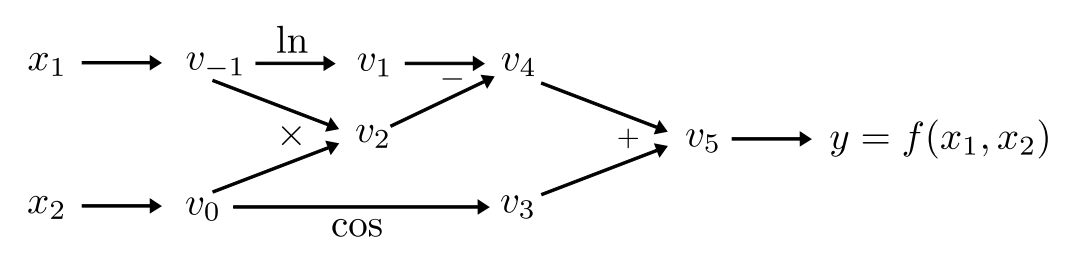

We are interested in calculating derivative of $y$ with respect to $v_i$, i.e. $\frac{\partial y_j}{\partial v_i} $. For a computational graph we can write the chain rule as
\begin{equation}
 \frac{\partial y_j}{\partial v_i} = \frac{\partial y_j}{\partial v_k}\frac{\partial v_k}{\partial v_i},
\end{equation}
where $v_k$ is a parent of a $v_i$ in a computational graph. When $v_i$ has more than one parent we sum up the chain rule as:
\begin{equation}
 \frac{\partial y_j}{\partial v_i} = \sum_{p\in parents(i)} \frac{\partial y_j}{\partial v_p}\frac{\partial v_p}{\partial v_i}.
\end{equation}
In the literature the above expression is called as $\textit{adjont}$ and denoted as
\begin{equation}
\bar{v}_i = \frac{\partial y_i}{\partial v_i}.
\end{equation}

Next, we can rewrite the adjont in term of the adjonts of the parents, i.e.
\begin{equation}
 \bar{v}_i = \sum_{p\in \text{parents(i)}} \bar{v}_p \frac{\partial v_p}{\partial v_i}
\end{equation}
which gives us a recursive algorithm node $y$ with setting starting point as $\bar{y} = 1$.

Let's write parents of each node in our example:
\begin{equation}
\begin{split}
 \text{parents}(i=5) &\to  y \\
 \text{parents}(i=4) &\to \{v_5\} \\
 \text{parents}(i=3) &\to \{v_5\} \\
 \text{parents}(i=2) &\to \{v_4\} \\
 \text{parents}(i=1) &\to \{v_4\} \\
 \text{parents}(i=0) &\to \{v_2, v_3\} \\
 \text{parents}(i=-1) &\to \{v_1, v_2\}\\
\end{split}
\end{equation}

Now we can write adjonts:
 \begin{equation}
 \begin{split}
  \bar{v}_5 & = \bar{y} \\
  \bar{v}_4 & = \bar{v}_5\frac{\partial v_5}{\partial v_4}\\
  \bar{v}_3 & = \bar{v}_5\frac{\partial v_5}{\partial v_3}\\
  \bar{v}_2 & = \bar{v}_4\frac{\partial v_4}{\partial v_2}\\
  \bar{v}_1 & = \bar{v}_4\frac{\partial v_4}{\partial v_1}\\
  \bar{v}_0 & = \bar{v}_2\frac{\partial v_2}{\partial v_0} + \bar{v}_3\frac{\partial v_3}{\partial v_0} \\
  \bar{v}_{-1} & = \bar{v}_1\frac{\partial v_1}{\partial v_{-1}} + \bar{v}_2\frac{\partial v_2}{\partial v_{-1}} \\
 \end{split}
 \end{equation}
 
 
Finally, we notice that
\begin{equation}
\begin{split}
 \bar{v}_0    & = \bar{x}_2 = \frac{\partial y}{\partial x_2}\\
 \bar{v}_{-1} & = \bar{x}_1 = \frac{\partial y}{\partial x_1}.
\end{split}
\end{equation}

In other words, with the single backward pass we have both $\frac{\partial y}{\partial x_1}$ and $\frac{\partial y}{\partial x_2}$ (in forward mode we can obtain $\frac{\partial y}{\partial x_1}$ in one pass).

::: {.callout-tip}
#### Exercise
Calculate value of $\frac{\partial f}{\partial x_1} = \dot{v}_5$ at $(x_1, x_2) = (2,1)$ through passing the diagram:
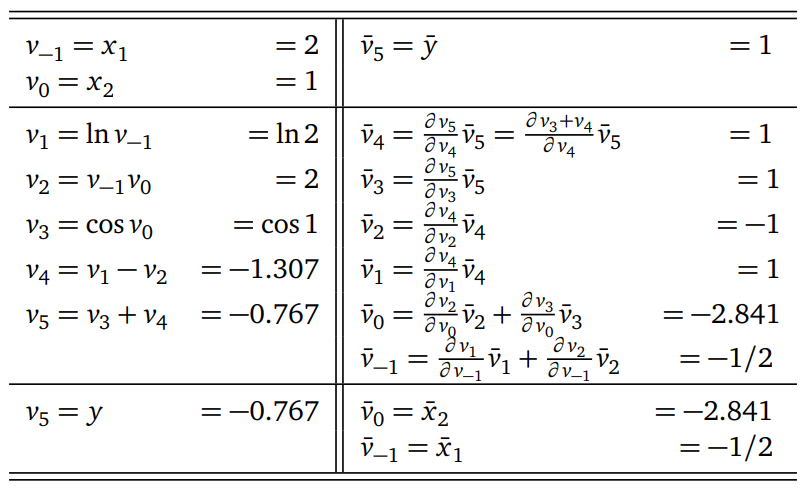
:::


## Calculating gradietns with PyTorch: torch.autograd

torch.autograd is PyTorch’s automatic differentiation engine that helps in neural network training.


### Example 1

To compute the gradient of a scalar function $f$ with respect to a single variable $x$, we can use PyTorch's autograd module. For example:

In [ ]:
import torch

# Create a tensor with requires_grad set to True
x = torch.tensor([4.0], requires_grad=True)

# Define a scalar function f
def f(x):
    return x ** 2

# Compute the gradient of f with respect to x
y = f(x)
y.backward()

# The gradient of f with respect to x is stored in x.grad
print(x.grad) 

tensor([8.])


### Example 2

To compute the gradient of a function with respect to multiple variables, we can pass a tensor with requires_grad set to True to the function and then use the backward method on the resulting tensor.  

In [ ]:
import torch

# Create tensors with requires_grad set to True
x = torch.tensor([1.0], requires_grad=True)
y = torch.tensor([1.0], requires_grad=True)
z = torch.tensor([1.0], requires_grad=True)
# Define a function that takes two variables as input and returns their sum
def f(x, y, z):
    return torch.log(torch.sin(x) + torch.tanh(y**2))/z

# Compute the gradient of f with respect to x and y
g = f(x, y, z)
g.backward()

# The gradients of f with respect to x and y are stored in x.grad and y.grad
print(x.grad)   
print(y.grad)   
print(z.grad)   

tensor([0.3370])
tensor([0.5240])
tensor([-0.4719])


### Example 3

Automatic differentiation can be used in more complicated problems.


Let us consider eigenproblem for quantum harmonic oscillator

\begin{equation}
\begin{split}
\hat{H}\psi_n(x) & = E_n(x)\psi_n(x) \\
\hat{H} & = -\frac{1}{2}\frac{\partial^2}{\partial x^2} + \frac{1}{2}x^2 + \kappa x^4
\end{split}
\end{equation}

We are interested in change of the ground state energy $E_{0}$ as a function of $\kappa$ parameter.
To tackle this problem, we have to first calculate eigenstates of the considered Hamiltonian. 

Let us consider equaly distributed set of points  $x_i$ lying in interval $[-L/2, L/2]$ with $\Delta x = \frac{L}{N_x}$, where $N_x$ is a number of discretization points.

First, we have to, i.e. solve the eigenproblem of the form
\begin{equation}
\bar{H}\vec{\psi}_n = E_n \vec{\psi}_n,
\end{equation}
where $\bar{H}$ is $N_x\times N_x$ matrix representation of Hamiltonian $\hat{H}$ in a discretized space. After constructing the matrix $\bar{H}$, we can diagonalize it, and find eigenvectors $\vec{\psi}_n$, and corresponding eigenvalues $E_n$. Note, $n\in \{0,N_x\}$.

::: {.callout-note}
### Discrete second-order derivative and Hamiltonian matrix representation
To construct the matrix representation of $\hat{H}$, we have to implement discrete second order derivative:
\begin{equation}
 \frac{\partial^2 \psi(x)}{\partial x^2}\big|_{x} \approx \frac{\psi_{i+1} - 2\psi_i + \psi_{i-1}}{\Delta x}
\end{equation}


The matrix representation of the kinetic part of the Hamiltonian $\hat{H}$ is

\begin{equation}
\bar{H}_{\text{T}} = -\frac{1}{2}\frac{1}{\Delta x}\begin{bmatrix}
-2 & 1 & 0 & 0 & 0 & . \\
1 & -2 & 1 & 0 & 0 & . \\
0 & 1 & -2 & 1 & 0 & . \\
0 & 0 & 1 & -2 & 1 & . \\
0 & 0 & 0 & 1 & -2 & 1 \\
. & . & . & . & . & . 
\end{bmatrix}  
\end{equation}

The matrix representation of the potential part of the Hamiltonian $\hat{H}$ is
a diagonal matrix elements $[\bar{H}_\text{V}]_{i,j} = \delta_{i,j} \big(\frac{1}{2}x_i^2 + \kappa^4x_i^4 \big)$

Now, the Hamiltonian matrix representation is simply $\bar{H} = \bar{H}_T + \bar{H}_V$.
:::



Let's import necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.linalg import eigh

Let's define function returning matrix of the considered Hamiltonian.

In [ ]:
def get_H(kappa):
    H_T = torch.zeros((Nx,Nx))
    ones = torch.ones(Nx)
    H_T = -0.5/dx**2*( torch.diag_embed(ones[:-1], offset = 1) - 2*torch.diag_embed(ones, offset = 0) + torch.diag_embed(ones[:-1], offset = -1))  
    H_V = torch.diag(0.5*x**2.0 + kappa*x**4.0)
    H = H_T + H_V
    return H

Pytorch function torch.eigh calculates eigenfunctions and eigenvalues of a given matrix

In [ ]:
def get_energy_ground_state(kappa):
    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    E_GS = Energies[0]
    return E_GS

Finally, let's define system size $L = 10$, $N_x = 500$ discretization points, and see density of few first eigenstates of the Hamiltonian for given parameter $\kappa$:

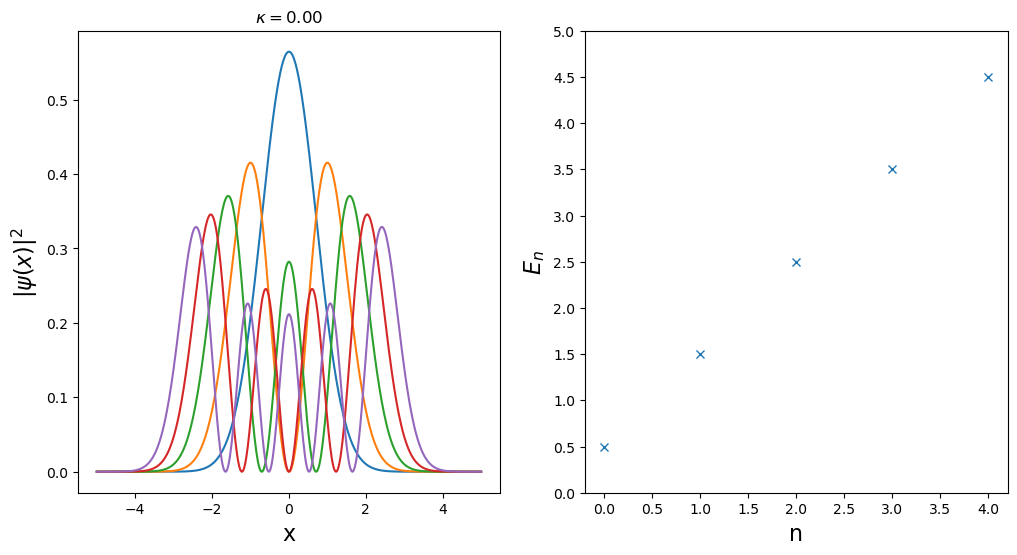

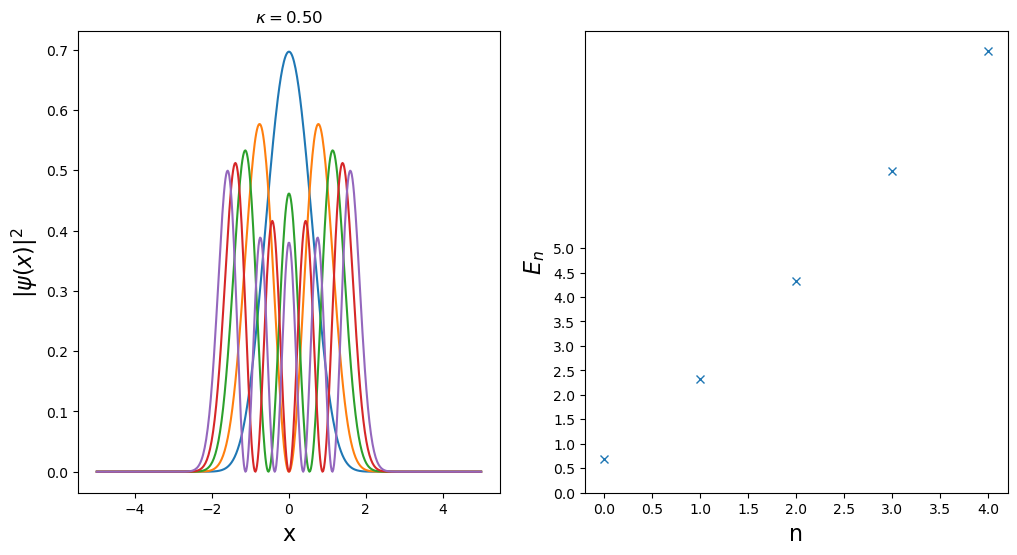

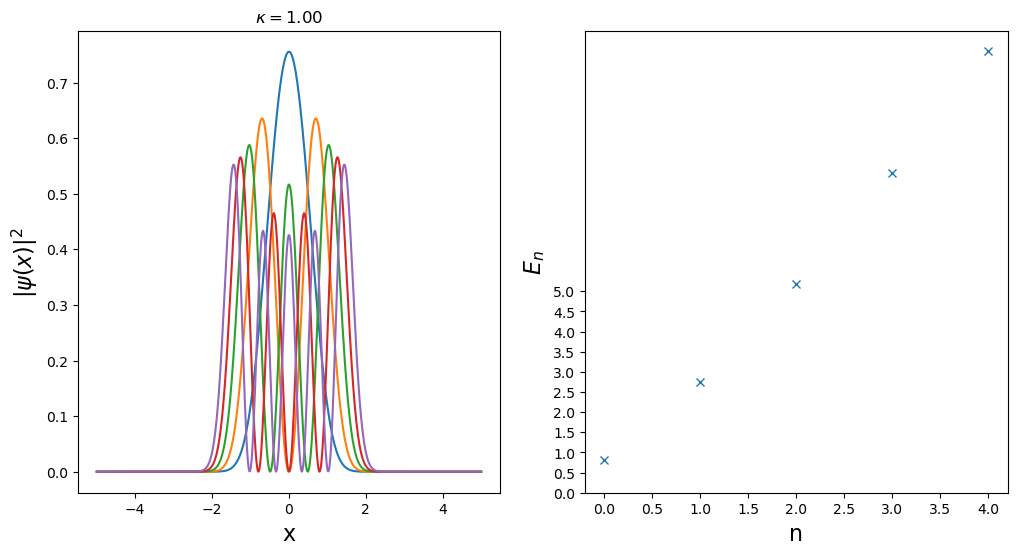

In [ ]:
L = 10
Nx = 500
x = torch.linspace(-L/2,L/2,Nx)
dx = x[1]-x[0]

kappa_vec = torch.tensor([0, 0.5, 1])

for kappa in kappa_vec:
    H = get_H(kappa)
    Energies, Vectors = eigh(H)
    rho = torch.abs(Vectors)**2/dx

    n_max = 5             # maximal number of eigenstates
    E_max = (n_max + 0.5) #
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    FontSize = 16
    ax[0].set_title(r"$\kappa = $" + "{:2.2f}".format(kappa.item()))
    for i in range(0,n_max):
        ax[0].plot(x,rho[:,i].detach().numpy())
    ax[1].plot(Energies[0:n_max].detach().numpy(),'x')
    ax[0].set_ylabel(r"$|\psi(x)|^2$",fontsize=FontSize)
    ax[0].set_xlabel("x",fontsize=FontSize)
    ax[1].set_ylabel(r"$E_n$",fontsize=FontSize)
    ax[1].set_xlabel(r"n",fontsize=FontSize)
    ax[1].set_yticks(np.arange(0,E_max,0.5))
    plt.show()


Now, let's check how ground state energy changes with $\kappa$:

Text(0, 0.5, 'ground state energy')

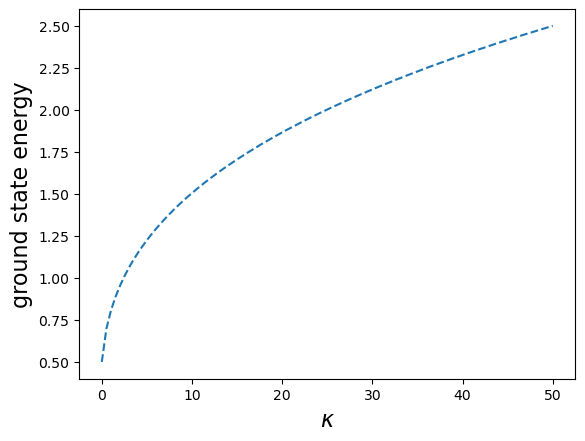

In [ ]:
fig = plt.figure()

## How ground state energy depends on kappa?
E_gs_vs_kappa = []
kappa_max = 50
kappa_vec = np.linspace(0,kappa_max,100)
for kappa in kappa_vec:
    E_gs_vs_kappa.append([get_energy_ground_state(kappa)])

plt.plot(kappa_vec, E_gs_vs_kappa, '--')
FontSize = 16
plt.xlabel(r"$\kappa$",fontsize=FontSize)
plt.ylabel(r"ground state energy",fontsize=FontSize)

Finally, let's calculate derivative $\frac{d E_{\text{GS}}(\kappa)}{d \kappa}$ at given $\kappa$ using torch.autograd:

In [ ]:
kappa_fixed = torch.tensor(10., requires_grad = True)
E_GS = get_energy_ground_state(kappa_fixed)
E_GS.backward()
print(kappa_fixed.grad)

tensor(0.0458)


Let's plot $\frac{d E_{\text{GS}}(\kappa)}{d \kappa}$:

Text(0, 0.5, '$\\frac{dE}{d\\kappa}$')

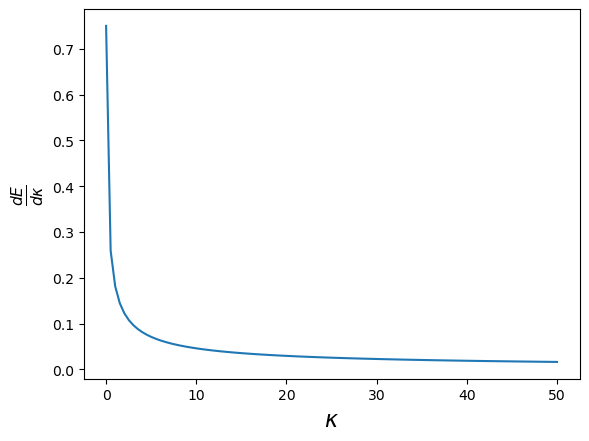

In [ ]:
N_kappa = 100
kappa_max = 50
kappa_vec = np.linspace(0,kappa_max,N_kappa)

dEdkappa = []
for kappa in kappa_vec:
    kappa_fixed = torch.tensor(kappa, requires_grad = True)
    E_GS = get_energy_ground_state(kappa_fixed)
    E_GS.backward()
    diff = kappa_fixed.grad
    dEdkappa.append([diff.item()])

plt.plot(kappa_vec,dEdkappa)
FontSize=16
plt.xlabel(r"$\kappa$",fontsize=FontSize)
plt.ylabel(r"$\frac{dE}{d\kappa}$",fontsize=FontSize)

# Gradients in a Deep Neural Network

We can then express the Neural Network  $K$ layers as a many-level function composition

\begin{equation}
 \vec{y} = (f_K\circ f_{K-1} \circ \dots f_1)(\vec{x}) = f_K(f_{K-1}(\cdots(f_1(\vec{x}))),
\end{equation}

where $\vec{x}$ are inputs, while $\vec{y}$ are outputs (e.g. predicted labels), and $j = 0,\dots,K$ enumerates layers of the network.
The input data flow can be decomposed in the following steps:

\begin{equation}
\begin{split}
  f_0 & \equiv x \\
  f_1 & = \sigma_1(W_0 f_0 + b_0) \\
  f_2 & = \sigma_2(W_1 f_1 + b_1) \\
  \vdots\\
  f_j & = \sigma_j(W_{i-1} f_{j-1} + b_{j-1})\\
  \vdots\\
  f_K & = \sigma_K(W_{K-1} f_{K-1} + b_{K}).
\end{split}
\end{equation}

Since we’ll mostly be discussing autograd in the context of training, our output of interest will be the model’s loss function $L$, which is a single-valued scalar function of the model’s output. This function expresses how far off our model’s prediction was from a particular input’s ideal output.  


We try to obtain that by an iterative process of passing the training data, and updating the weights according to gradient of the loss function with respect to the training parameters $\theta = \{W_0, b_0, W_1, b_1, \dots, A_{K-1}, b_k\}$. The gradient of the loss function with respect to the parameters set $\theta$ requires the partial derivatives with respect to $\theta_j = \{W_j, b_j\}$ of each layer $j = 1,\dots,K$:

\begin{equation}
 \begin{split}
  \frac{\partial L}{\partial \theta_{K-1}} & = \frac{\partial L}{\partial f_K}\color{blue}{ \frac{\partial f_K}{\partial \theta_{K-1}}} \\
  \frac{\partial L}{\partial \theta_{K-2}} & = \frac{\partial L}{\partial f_K}\color{red}{ \frac{\partial f_K}{\partial f_{K-1}}}\color{blue}{ \frac{\partial f_{K-1}}{\partial \theta_{K-2}}} \\
  \frac{\partial L}{\partial \theta_{K-3}} & = \frac{\partial L}{\partial f_K}\color{red}{ \frac{\partial f_K}{\partial f_{K-1}}}\color{red}{ \frac{\partial f_{K-1}}{\partial f_{K-2}}}\color{blue}{ \frac{\partial f_{K-2}}{\partial \theta_{K-3}}} \\
  \frac{\partial L}{\partial \theta_{K-4}} & = \frac{\partial L}{\partial f_K}\color{red}{ \frac{\partial f_K}{\partial f_{K-1}}}\color{red}{ \frac{\partial f_{K-1}}{\partial f_{K-2}}}\color{red}{ \frac{\partial f_{K-2}}{\partial f_{K-3}}}\color{blue}{ \frac{\partial f_{K-3}}{\partial \theta_{K-4}}} \\
  \vdots
 \end{split}
\end{equation}

As such, assuming we have already computed $\frac{\partial L}{\partial \theta_{i+1}}$ it can be reused to compute $\frac{\partial L}{\partial \theta_{i}}$ - which is a reverse-mode AD.

Autograd lies at the heart of building machine learning projects. It allows automatic calculation of gradient of the custom loss function for the Neural Network with respect to it's parameters.
